In [1]:
from rdkit import Chem
from mordred import Calculator, descriptors
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

In [10]:
calc = Calculator(descriptors, ignore_3D=True)

def get_desc(smile):
    mol = Chem.MolFromSmiles(smile)
    return calc(mol)

#### Загрузка датасета

In [4]:
df = pd.read_csv('data/ld50_oral_rat/output_big_df.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,smiles,label
0,[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,BrC(Br)Br,2.343
2,C=CBr,2.330
3,Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,S=C=Nc1ccc(Br)cc1,2.729
...,...,...
7337,O=C=Nc1ccccc1C(F)(F)F,1.427
7338,Nc1ccc(OC(F)(F)C(F)F)c(N)c1,2.321
7339,CC(=O)OCCN(CCC#N)c1ccccc1,2.050
7340,CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


In [2]:
# загрузка сразу предобработанного датасет

X = np.array(pd.read_csv('data/ld50_oral_rat/pre/7342_all_X.csv'))
y = np.array(df['label'])

X.shape, y.shape

((7342, 1613), (7342, 1))

In [ ]:
X = np.array(list(map(lambda x: get_desc(x), df['smiles'])), dtype=float)
y = np.array(df['label'])

X.shape, y.shape

#### Пример молекулы

c1cc(-c2ccncc2)ccn1


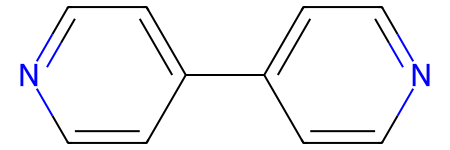

In [5]:
view = df.iloc[73]
view_mol = Chem.MolFromSmiles(view['smiles'])
print(view['smiles'])
view_mol

#### Разделение на обучающую и тренировочную выборки

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [6]:
def print_metrics(y_test, y_pred):
    print(
        f'MAE: {mean_absolute_error(y_test, y_pred)}\n'
        f'MSE: {mean_squared_error(y_test, y_pred)}\n'
        f'MAPE: {mean_absolute_percentage_error(y_test, y_pred)}\n'
        f'R^2: {r2_score(y_test, y_pred)}\n'
        f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}'
    )

## Tensorflow (неудачно)

In [80]:
X_tf = np.where(np.isnan(X), 0, X)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf, y, test_size=0.33, random_state=0)

In [81]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1024, activation="linear", input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(512, activation="sigmoid"),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(256, activation="sigmoid"),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(128, activation="sigmoid"),
        tf.keras.layers.Dropout(0.01),
        tf.keras.layers.Dense(1, activation="linear", kernel_regularizer='l2'),
    ]
)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_83 (Dense)            (None, 1024)              1652736   
                                                                 
 dense_84 (Dense)            (None, 512)               524800    
                                                                 
 dropout_39 (Dropout)        (None, 512)               0         
                                                                 
 dense_85 (Dense)            (None, 256)               131328    
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_86 (Dense)            (None, 128)               32896     
                                                                 
 dropout_41 (Dropout)        (None, 128)             

In [82]:
model.fit(X_train_tf, y_train_tf, epochs=5)

Epoch 1/5
154/154 [==============================] - 5s 26ms/step - loss: 1.1040
Epoch 2/5
154/154 [==============================] - 4s 25ms/step - loss: 0.9538
Epoch 3/5
154/154 [==============================] - 4s 25ms/step - loss: 0.9761
Epoch 4/5
154/154 [==============================] - 4s 25ms/step - loss: 0.9607
Epoch 5/5
154/154 [==============================] - 4s 25ms/step - loss: 0.9547


In [83]:
y_pred_tf = model.predict(X_test_tf)
y_pred_tf[:3]

76/76 [==============================] - 1s 6ms/step


array([[2.4842105],
       [2.4842105],
       [2.4842105]], dtype=float32)

In [84]:
print_metrics(y_test_tf, y_pred_tf)

MAE: 0.7286786911799502
MSE: 0.9140625557763256
MAPE: 0.3208899201152867
R^2: -0.004858076282287627
RMSE: 0.9560661879683464


## sklearn

### Проверили кросс-валидацию

In [85]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
rmse = []

for train_index, test_index in kfold.split(X, y):
    xgbr = XGBRegressor().fit(X[train_index], y[train_index])
    y_pred_xgbr = xgbr.predict(X[test_index])
    rmse.append(np.sqrt(mean_squared_error(y[test_index], y_pred_xgbr)))
    print('RMSE:', rmse[-1], end='\n\n')

print(np.mean(rmse))

RMSE: 0.6157041119434946

RMSE: 0.6171983452899202

RMSE: 0.66428106269451

RMSE: 0.595739193809463

RMSE: 0.6412679714413013

0.6268381370357379


In [86]:
xgbr_kf = XGBRegressor(early_stopping_rounds=10, random_state=0, seed=0).fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
y_pred_xgbr_kf = xgbr_kf.predict(X_test)
print_metrics(y_test, y_pred_xgbr_kf)

[0]	validation_0-rmse:1.65065	validation_1-rmse:1.67897
[1]	validation_0-rmse:1.24167	validation_1-rmse:1.28022
[2]	validation_0-rmse:0.96735	validation_1-rmse:1.02464
[3]	validation_0-rmse:0.79071	validation_1-rmse:0.86933
[4]	validation_0-rmse:0.67636	validation_1-rmse:0.77102
[5]	validation_0-rmse:0.59982	validation_1-rmse:0.71511
[6]	validation_0-rmse:0.55251	validation_1-rmse:0.68756
[7]	validation_0-rmse:0.51898	validation_1-rmse:0.67182
[8]	validation_0-rmse:0.49379	validation_1-rmse:0.66215
[9]	validation_0-rmse:0.47428	validation_1-rmse:0.65645
[10]	validation_0-rmse:0.46111	validation_1-rmse:0.65096
[11]	validation_0-rmse:0.45029	validation_1-rmse:0.64862
[12]	validation_0-rmse:0.44485	validation_1-rmse:0.64725
[13]	validation_0-rmse:0.44104	validation_1-rmse:0.64619
[14]	validation_0-rmse:0.43350	validation_1-rmse:0.64531
[15]	validation_0-rmse:0.42655	validation_1-rmse:0.64494
[16]	validation_0-rmse:0.41856	validation_1-rmse:0.64349
[17]	validation_0-rmse:0.41313	validation

In [87]:
results = xgbr_kf.evals_result()
results['validation_1']['rmse'][-1]

0.628136739649948

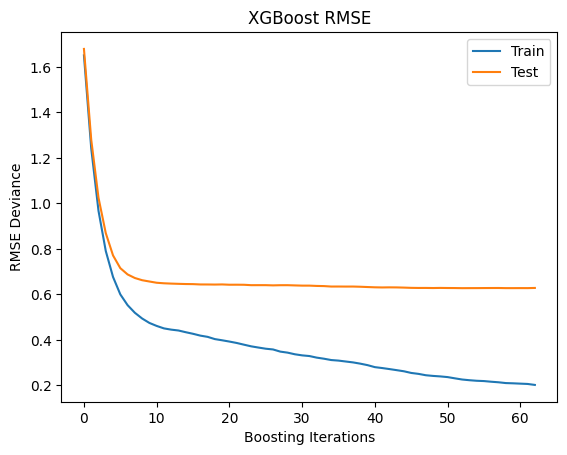

In [88]:
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()

ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')

plt.title('XGBoost RMSE')
plt.xlabel("Boosting Iterations")
plt.ylabel("RMSE Deviance")
plt.legend(loc="upper right")

### XGB

In [89]:
xgbr = XGBRegressor().fit(X_train, y_train)
y_pred_xgbr = xgbr.predict(X_test)
print_metrics(y_test, y_pred_xgbr)

MAE: 0.46666002014339636
MSE: 0.39459896661517996
MAPE: 0.20284834173937
R^2: 0.5662047898251974
RMSE: 0.6281711284476388


### CatBoost

In [90]:
cbr = CatBoostRegressor().fit(X_train, y_train, verbose=False)
y_pred_cbr = cbr.predict(X_test)
print_metrics(y_test, y_pred_cbr)

MAE: 0.438331975426378
MSE: 0.35227014925337635
MAPE: 0.19169357899294656
R^2: 0.6127382067305219
RMSE: 0.5935235035391407


Можно бы было подобрать много гиперпараметров, но у нас нет столько мощностей

In [8]:
params = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [3, 5, 7],
    'random_seed': [42],
    'bagging_temperature': [0.6, 0.8, 1],
    'border_count': [32, 64, 128]
}

cb = CatBoostRegressor(task_type="GPU", devices="0:1") 

grid = GridSearchCV(estimator=cb, param_grid=params, n_jobs=4, verbose=3)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
